Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: colorspace

Loading required package: khroma

Loading required package: ggplot2

Loading required package: ggpattern

Loading required package: reshape2

Loading required package: tidyverse

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
✔ readr     2.1.4     
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_confl

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[[14]]
[1] TRUE

[[15]]
[1] TRUE

[[16]]
[1] TRUE

[[17]]
[1] TRUE

[[18]]
[1] TRUE

[[19]]
[1] TRUE

[[20]]
[1] TRUE

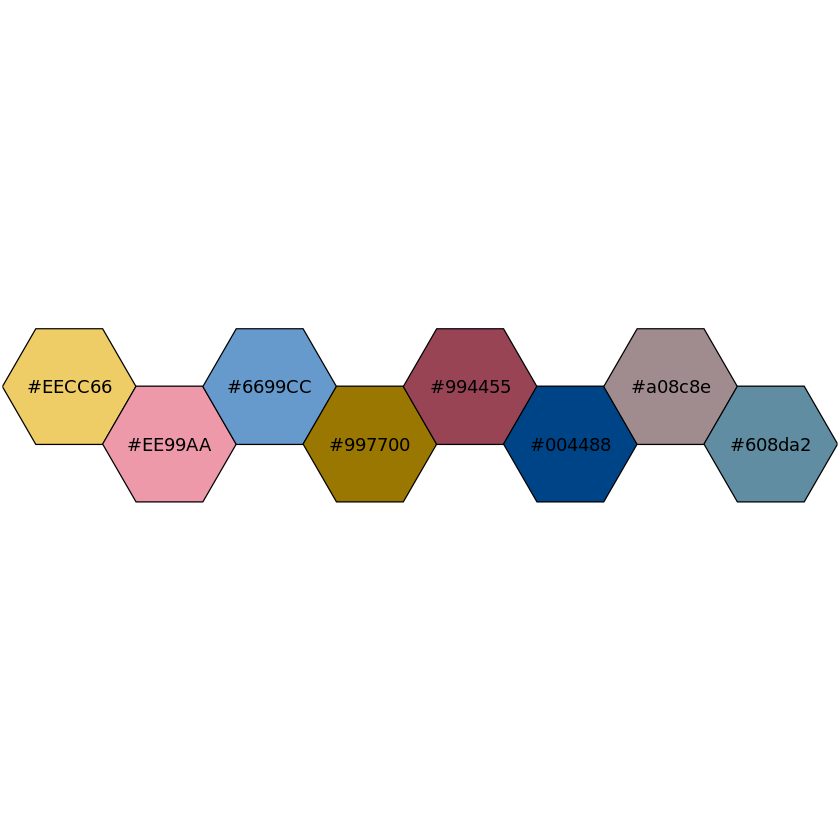

In [1]:
f_func <- "../functions.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_func, '--to=script', '--stdout'), stdout = TRUE)))
f_path <- "../dirs.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_path, '--to=script', '--stdout'), stdout = TRUE)))
f_cols <- "../cols.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_cols, '--to=script', '--stdout'), stdout = TRUE)))

In [2]:
sample_nm <- c()
step_nm <- c()
for (file in list.files(SPL_STATS_DIR, pattern = "R1")){
    sample_nm <- c(sample_nm, unlist(strsplit(file, '_'))[1])
    step_nm <- c(step_nm, paste0(unlist(strsplit(file, '_'))[3], unlist(strsplit(file, '_'))[4]))
}
mt <- matrix(ncol = length(unique(sample_nm)), nrow = length(unique(step_nm)))
colnames(mt) <- unique(sample_nm)
rownames(mt) <- unique(step_nm)
for (file in list.files(SPL_STATS_DIR)){
    sample <- unlist(strsplit(file, '_'))[1]
    step <- paste0(unlist(strsplit(file, '_'))[3], unlist(strsplit(file, '_'))[4])
    line_count <- read.csv(file = paste0(SPL_STATS_DIR,file), header=FALSE, sep = "\t", stringsAsFactors=FALSE)
    mt[step, sample] <- line_count[1,1]
}

In [3]:
nm_oi <- list_oi <- c("Archaea", "Bacteria", "Fungi", "Viruses", "Homo sapiens")
mt_t <- matrix(ncol = 7, nrow = length(nm_oi))
colnames(mt_t) <- c("sample", "taxa", "db", "conf",
                    "percentage", "count", "minimizers_est")
rownames(mt_t) <- nm_oi

if(exists("build_df")){rm("build_df")}
for (file in list.files(SPL_K2_REP, recursive = TRUE, pattern = paste0("*.report"))){
    if(grepl(file, pattern = "_RS")){
        mt_tmp <- mt_t
        smpl <- gsub(file, pattern = "_.*", replacement = "")
        mt_tmp[,"sample"] <- gsub(file, pattern = "_.*", replacement = "")
        mt_tmp[,"conf"] <- gsub(gsub(gsub(file, pattern = ".report", replacement = ""), 
                                               pattern = ".*_", replacement = ""), 
                                               pattern = "conf", replacement = "")
        smpl_db <- gsub(gsub(file, pattern = "_conf.*", replacement = ""), pattern = ".*/", replacement = "")
        
        if(grepl(file, pattern = "_RS_conf")){mt_tmp[,"db"] <- "RS"}
        if(grepl(file, pattern = "_RS_minusT2T_conf")){mt_tmp[,"db"] <- "RS w/o CHM13v2"}                                          

        k2prep <- read.csv(paste0(SPL_K2_REP, file), header=FALSE, sep = "\t", stringsAsFactors=FALSE)
        k2prep$V8 <- str_trim(k2prep$V8, side = "left")
        for (i in nm_oi){
            mt_tmp[i,"taxa"] <- i
            mt_tmp[i,"count"] <- as.numeric(k2prep$V2[which(k2prep$V8 == i)])
            mt_tmp[i,"minimizers_est"] <- as.numeric(k2prep$V5[which(k2prep$V8 == i)])
        }

        QC_rc <- mt["04adapt", smpl]
        mt_tmp[,"percentage"] <- as.numeric(mt_tmp[,"count"])/QC_rc*10^6

        if(!exists("build_df")){build_df <- mt_tmp} else {build_df <- rbind(build_df, mt_tmp)}
    }
}

In [4]:
k2_build_data <- data.frame(build_df) %>% 
    mutate(sample_short = str_replace(sample, str_sub(sample, 1, 3), "")) %>%
    filter(sample_short %in% c("Bctrl", "Pctrl")) %>% 
    mutate(sample_short = ifelse(sample_short == "Bctrl", yes = "BAL fluid, control", no = sample_short))  %>% 
    mutate(sample_short = ifelse(sample_short == "Pctrl", yes = "plasma, control", no = sample_short))  %>% 
    filter(!grepl(sample, pattern = "[A-Z]$")) %>% 
    filter(grepl(sample, pattern = "^H")) %>%  
    filter(sample %nin% c("H02Bctrl", "H23Bctrl"))  %>% 
    mutate(percentage = as.numeric(percentage)) %>%
    mutate(minimizers_est = as.numeric(minimizers_est)) %>% 
    mutate(count = as.numeric(count))  %>% 
    mutate(taxa = factor(taxa, levels = c("Homo sapiens", "Archaea", "Bacteria", "Fungi", "Viruses")))

In [5]:
k2_build_norm <- k2_build_data
for (i in 1:nrow(k2_build_data)){
    k2_build_norm[i,c("percentage", "count", "minimizers_est")] = 
        as.numeric(k2_build_norm[i,c("percentage", "count", "minimizers_est")])/ 
            as.numeric(k2_build_norm[which(k2_build_norm$sample == k2_build_norm$sample[i] &
            k2_build_norm$taxa == k2_build_norm$taxa[i] & 
            k2_build_norm$conf == k2_build_norm$conf[i] & 
            grepl(k2_build_norm$db, pattern = "RS w/o CHM13v2")),c("percentage", "count", "minimizers_est")]) 
}
options(repr.plot.width=7, repr.plot.height=7)
plt_hs_norm <- k2_build_norm %>% 
    filter(db == "RS") %>% 
    filter(taxa == "Homo sapiens") %>% 
    mutate(taxa = paste0(taxa, " (S)")) %>% 
    ggplot() + 
        geom_line(aes(x = conf, y = count, group = sample, col = sample_short), 
                  linewidth = 3, alpha = 0.3) + theme_bw() + 
        geom_line(data = k2_build_norm %>% 
                                filter(db == "RS") %>% 
                                filter(taxa == "Homo sapiens") %>% 
                                mutate(taxa = paste0(taxa, " (S)")) %>% 
                                group_by(conf, taxa) %>% 
                                summarise(avg_count = mean(count, na.rm = TRUE), .groups = "keep"), 
                  aes(x = conf, y = avg_count, group = taxa), col = "grey28", linewidth = 2.5, linetype = "dotted") +
        ylim(0.98,1.12) + labs(color = "") + 
        ylab("Normalized Host Read Counts\nuR.7 : uR.7 w/o CHM13v2") + xlab("Confidence Threshold") +
        scale_color_manual(values=alpha(c(colors_mc), 0.3)) + 
        theme_bw() + theme(legend.position = c(0.95, 0.25),
            legend.justification = c("right", "top"),
            legend.box.just = "right",
            legend.margin = margin(6, 6, 6, 6)
        ) +
        facet_grid(cols = vars(taxa)) +
        ggtitle("")

Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2 3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”


In [14]:
file_list <- list.files(pattern = "_RS_conf", path = SPL_K2_OUT)

report_RS = read.delim(file = list.files(path = SPL_K2_REP, 
                                         pattern = "RS_conf", full.names = TRUE)[1], 
                                         header = FALSE)
txd_nm_RS <- report_RS[, c(ncol(report_RS)-2):ncol(report_RS)]
colnames(txd_nm_RS) <- c("taxLvl", "taxID", "name")
txd_nm_RS <- txd_nm_RS %>% mutate(name = str_trim(name, side = "left"))

if(exists("read_tracing")){rm("read_tracing")}
for (f in file_list){
    if(grepl(f, pattern = "^H") & f %nin% c("H02Bctrl", "H23Bctrl")){
        tmp_out_RS <- read.delim(
            file = paste0(SPL_K2_OUT, f), sep = "\t", header = FALSE)
        tmp_out_RS_minusT2T <- read.delim(
            file = paste0(SPL_K2_OUT, gsub(f, pattern = "RS", replacement = "RS_minusT2T")), 
            sep = "\t", header = FALSE)
        rn_hm <- tmp_out_RS %>% dplyr::rename(taxID = "V3") %>% filter(taxID == "9606") %>% select("V2")
        
        add_to_tracing  <- tmp_out_RS_minusT2T %>% 
            filter(V2 %in% unlist(rn_hm)) %>% 
            dplyr::rename(taxID = "V3") %>% 
            select("taxID") %>% mutate(name = f) %>% 
            group_by(name, taxID) %>% 
            summarise(n=n(), .groups = "keep") %>% 
            mutate(taxID = as.factor(taxID)) %>% 
            mutate(taxa = sapply(taxID, function(x) paste0(
                str_trim(txd_nm_RS$name[txd_nm_RS$taxID == x], side = "left"), " (", 
                txd_nm_RS$taxLvl[txd_nm_RS$taxID == x], ")"))) %>% 
            mutate(taxa_lvl = sapply(taxID, function(x) txd_nm_RS$taxLvl[txd_nm_RS$taxID == x]))
        add_to_tracing[,"QC_rc"] <- mt["04adapt",gsub(f, pattern = "_.*", replacement = "")]
        if(exists("read_tracing")){read_tracing <- rbind(read_tracing, add_to_tracing)}
        else{read_tracing <- add_to_tracing}
    }
}
for (i in 1:nrow(read_tracing)){
    index_micr <- which(txd_nm_RS$name %in% c("unclassified", "root", "other entries",
                                              "Eukaryota", "Bacteria", "Viruses", "Fungi", "Eukaryota", "Fungi incertae sedis", "Protozoa", 
                            "Opisthokonta", "Amoebozoa", "Discoba", "Sar","Archaea")) 
        #which(txd_nm_RS$name %in% c("unclassified", "root", "other entries",
        #                                          "Eukaryota", "Bacteria", "Viruses", "Fungi", "Sar", "Discoba", "Archaea"))
    names(index_micr) <- txd_nm_RS$name[index_micr]
    
    index <- which(txd_nm_RS$taxID == c(read_tracing$taxID[i]))
    read_tracing[i,"domain"] = names(which(index_micr <= index)[max(which(index_micr <= index))])
}

In [7]:
options(repr.plot.width=20, repr.plot.height=20)
plt_micr <- read_tracing %>% 
    filter(domain %in% c("Archaea", "Bacteria", "Fungi", "Viruses")) %>% 
    filter(taxID != "9606") %>% 
    filter(domain %nin% c("unclassified", "root", "other entries", "Eukaryota")) %>% 
    mutate(sample = gsub(name, pattern = "_.*", replacement = "")) %>% 
    mutate(conf = gsub(gsub(name, pattern = ".output_classified", replacement = ""), 
                       pattern = ".*conf", replacement = "")) %>% 
    group_by(taxa, taxID, taxa_lvl, conf, domain) %>% 
    summarise(mean_n = mean(n), .groups = "keep") %>% 
    mutate(taxa_lvl_short = substr(taxa_lvl, 1, 1)) %>%
    mutate(taxa_lvl_short = ifelse(taxa_lvl_short == "C", yes = "Class", no = taxa_lvl_short)) %>% 
    mutate(taxa_lvl_short = ifelse(taxa_lvl_short == "D", yes = "Domain", no = taxa_lvl_short)) %>% 
    mutate(taxa_lvl_short = ifelse(taxa_lvl_short == "F", yes = "Family", no = taxa_lvl_short)) %>% 
    mutate(taxa_lvl_short = ifelse(taxa_lvl_short == "G", yes = "Genus", no = taxa_lvl_short)) %>% 
    mutate(taxa_lvl_short = ifelse(taxa_lvl_short == "K", yes = "Kingdom", no = taxa_lvl_short)) %>% 
    mutate(taxa_lvl_short = ifelse(taxa_lvl_short == "O", yes = "Order", no = taxa_lvl_short)) %>% 
    mutate(taxa_lvl_short = ifelse(taxa_lvl_short == "P", yes = "Phylum", no = taxa_lvl_short)) %>% 
    mutate(taxa_lvl_short = ifelse(taxa_lvl_short == "S", yes = "Species", no = taxa_lvl_short)) %>% 
    mutate(taxa_lvl_short = factor(taxa_lvl_short, 
        levels = c("Unclassified", "Root", "Domain", "Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species"))) %>% 
    ggplot(aes(x = conf, y = mean_n, fill = taxa_lvl_short)) +
        geom_bar(position="stack", stat="identity") + 
        theme_bw() + theme(legend.position = c(0.87, 0.99),
            legend.justification = c("right", "top"),
            legend.box.just = "right",
            legend.margin = margin(6, 6, 6, 6)) + 
        ylab("Mean Read Count") + xlab("Confidence Threshold") +  
        facet_grid(rows = vars(domain), scales = "free_y") + 
        scale_fill_manual(values = alpha(rev(colors_mut), alpha = 0.9)) + 
        labs(fill = "")

In [15]:
options(repr.plot.width=10, repr.plot.height=9)
plt_hs <- read_tracing %>% 
    filter(taxID == "9606") %>% 
    mutate(sample = gsub(name, pattern = "_.*", replacement = "")) %>% 
    mutate(conf = gsub(gsub(name, pattern = ".output_classified", replacement = ""), 
                       pattern = ".*conf", replacement = "")) %>% 
    group_by(taxa, taxID, taxa_lvl, conf, domain) %>% 
    summarise(mean_n = mean(n), .groups = "keep") %>% 
    mutate(taxa_lvl_short = substr(taxa_lvl, 1, 1)) %>%
    ggplot(aes(x = conf, y = mean_n)) +
        geom_bar(position="stack", stat="identity", col = "lightgrey") + 
        theme_bw() + theme(legend.position = c(0.95, 0.98),
            legend.justification = c("right", "top"),
            legend.box.just = "right",
            legend.margin = margin(6, 6, 6, 6)) +
        ylab("Mean Read Count") + xlab("Confidence Threshold") +  
        facet_grid(cols = vars(taxa)) +
        labs(fill="")

In [16]:
options(repr.plot.width=20, repr.plot.height=20)
plt_fun <- read_tracing %>% 
    filter(taxID != "9606") %>% 
    filter(domain == "Fungi") %>% 
    mutate(sample = gsub(name, pattern = "_.*", replacement = "")) %>% 
    mutate(conf = gsub(gsub(name, pattern = ".output_classified", replacement = ""), 
                       pattern = ".*conf", replacement = "")) %>% 
    mutate(taxa_short = gsub(taxa, pattern = " .*", replacement = "")) %>% 
    mutate(taxa_short = gsub(taxa_short, pattern = "\\[|]", replacement = "Candida")) %>% 
    mutate(taxa_short = ifelse(taxa_short == "CandidaCandidaCandida", yes = "Candida", no = taxa_short)) %>% 
    mutate(taxa_lvl_short = substr(taxa_lvl, 1, 1)) %>% 
    filter(taxa_lvl_short == "S") %>% 
    group_by(taxa_short, conf, domain) %>% 
    summarise(mean_n = mean(n), nr_unique_taxa = length(unique(taxa)), .groups = "keep") %>% 
    mutate(conf = as.numeric(conf)) %>% 
    ggplot(aes(x = conf, y = mean_n, fill = taxa_short), alpha = 0.5) +
        geom_bar(position="stack", stat="identity") + 
        theme_bw() +
        ylab("Mean Read Count") + xlab("Confidence Threshold") +
        geom_text(aes(x = conf, y = mean_n, 
            label = paste0(taxa_short, " (n=", nr_unique_taxa, ";mu=", round(mean_n, digits = 0), ")")), 
                  position = position_stack(vjust = 0.5), size = 5) + guides(fill = FALSE) + 
        scale_fill_manual(values = alpha(smooth_rainbow(42, range = c(0.25, 1)), alpha = 0.5)) + 
        facet_grid(rows = vars(domain)) 

In [24]:
test <- read_tracing %>% filter(domain == "Fungi") %>% filter(grepl(taxa_lvl, pattern = "S")) %>% select("taxa") 

test$taxa %>% unique()

Adding missing grouping variables: `name`, `taxID`


[1] "Pichia kudriavzevii (S)"                        
 [2] "Puccinia triticina (S)"                         
 [3] "Botrytis cinerea B05.10 (S1)"                   
 [4] "Candida dubliniensis CD36 (S1)"                 
 [5] "Kluyveromyces marxianus DMKU3-1042 (S1)"        
 [6] "Naumovozyma castellii CBS 4309 (S1)"            
 [7] "Aspergillus luchuensis (S)"                     
 [8] "Aspergillus oryzae RIB40 (S1)"                  
 [9] "Drechmeria coniospora (S)"                      
[10] "Fusarium falciforme (S)"                        
[11] "Candida orthopsilosis Co 90-125 (S1)"           
[12] "Fusarium oxysporum (S)"                         
[13] "Talaromyces marneffei (S)"                      
[14] "Puccinia striiformis f. sp. tritici (S1)"       
[15] "Thermothielavioides terrestris NRRL 8126 (S1)"  
[16] "Colletotrichum higginsianum IMI 349063 (S1)"    
[17] "Fusarium pseudograminearum CS3096 (S1)"         
[18] "Pyricularia oryzae 70-15 (S1)"                  
[19] "Fulvia fulva (S)"                               
[20] "Aspergillus fumigatus Af293 (S1)"               
[21] "Pochonia chlamydosporia 170 (S1)"               
[22] "Pyricularia pennisetigena (S)"                  
[23] "Candida albicans SC5314 (S1)"                   
[24] "Zymoseptoria tritici IPO323 (S1)"               
[25] "[Candida] auris (S)"                            
[26] "Fusarium poae (S)"                              
[27] "Cercospora beticola (S)"                        
[28] "Pyricularia grisea (S)"                         
[29] "Psilocybe cubensis (S)"                         
[30] "Sporisorium graminicola (S)"                    
[31] "Eremothecium cymbalariae DBVPG#7215 (S1)"       
[32] "Tetrapisispora phaffii CBS 4417 (S1)"           
[33] "Saccharomyces cerevisiae S288C (S1)"            
[34] "Scheffersomyces stipitis CBS 6054 (S1)"         
[35] "Naumovozyma dairenensis CBS 421 (S1)"           
[36] "Ustilaginoidea virens (S)"                      
[37] "Fusarium keratoplasticum (S)"                   
[38] "Saccharomyces paradoxus (S)"                    
[39] "Ustilago maydis 521 (S1)"                       
[40] "Neurospora crassa OR74A (S1)"                   
[41] "Fusarium oxysporum f. sp. lycopersici 4287 (S2)"
[42] "Sugiyamaella lignohabitans (S)"                 
[43] "Purpureocillium takamizusanense (S)"            
[44] "Fusarium venenatum (S)"                         
[45] "Brettanomyces nanus (S)"                        
[46] "Marasmius oreades (S)"                          
[47] "Fusarium graminearum PH-1 (S1)"                 
[48] "Tetrapisispora blattae CBS 6284 (S1)"           
[49] "Fusarium musae (S)"                             
[50] "Brettanomyces bruxellensis (S)"                 
[51] "Talaromyces rugulosus (S)"                      
[52] "Aspergillus puulaauensis (S)"                   
[53] "Torulaspora delbrueckii (S)"                    
[54] "Fusarium verticillioides 7600 (S1)"             
[55] "Rhizoctonia solani (S)"                         
[56] "Thermothelomyces thermophilus ATCC 42464 (S1)"

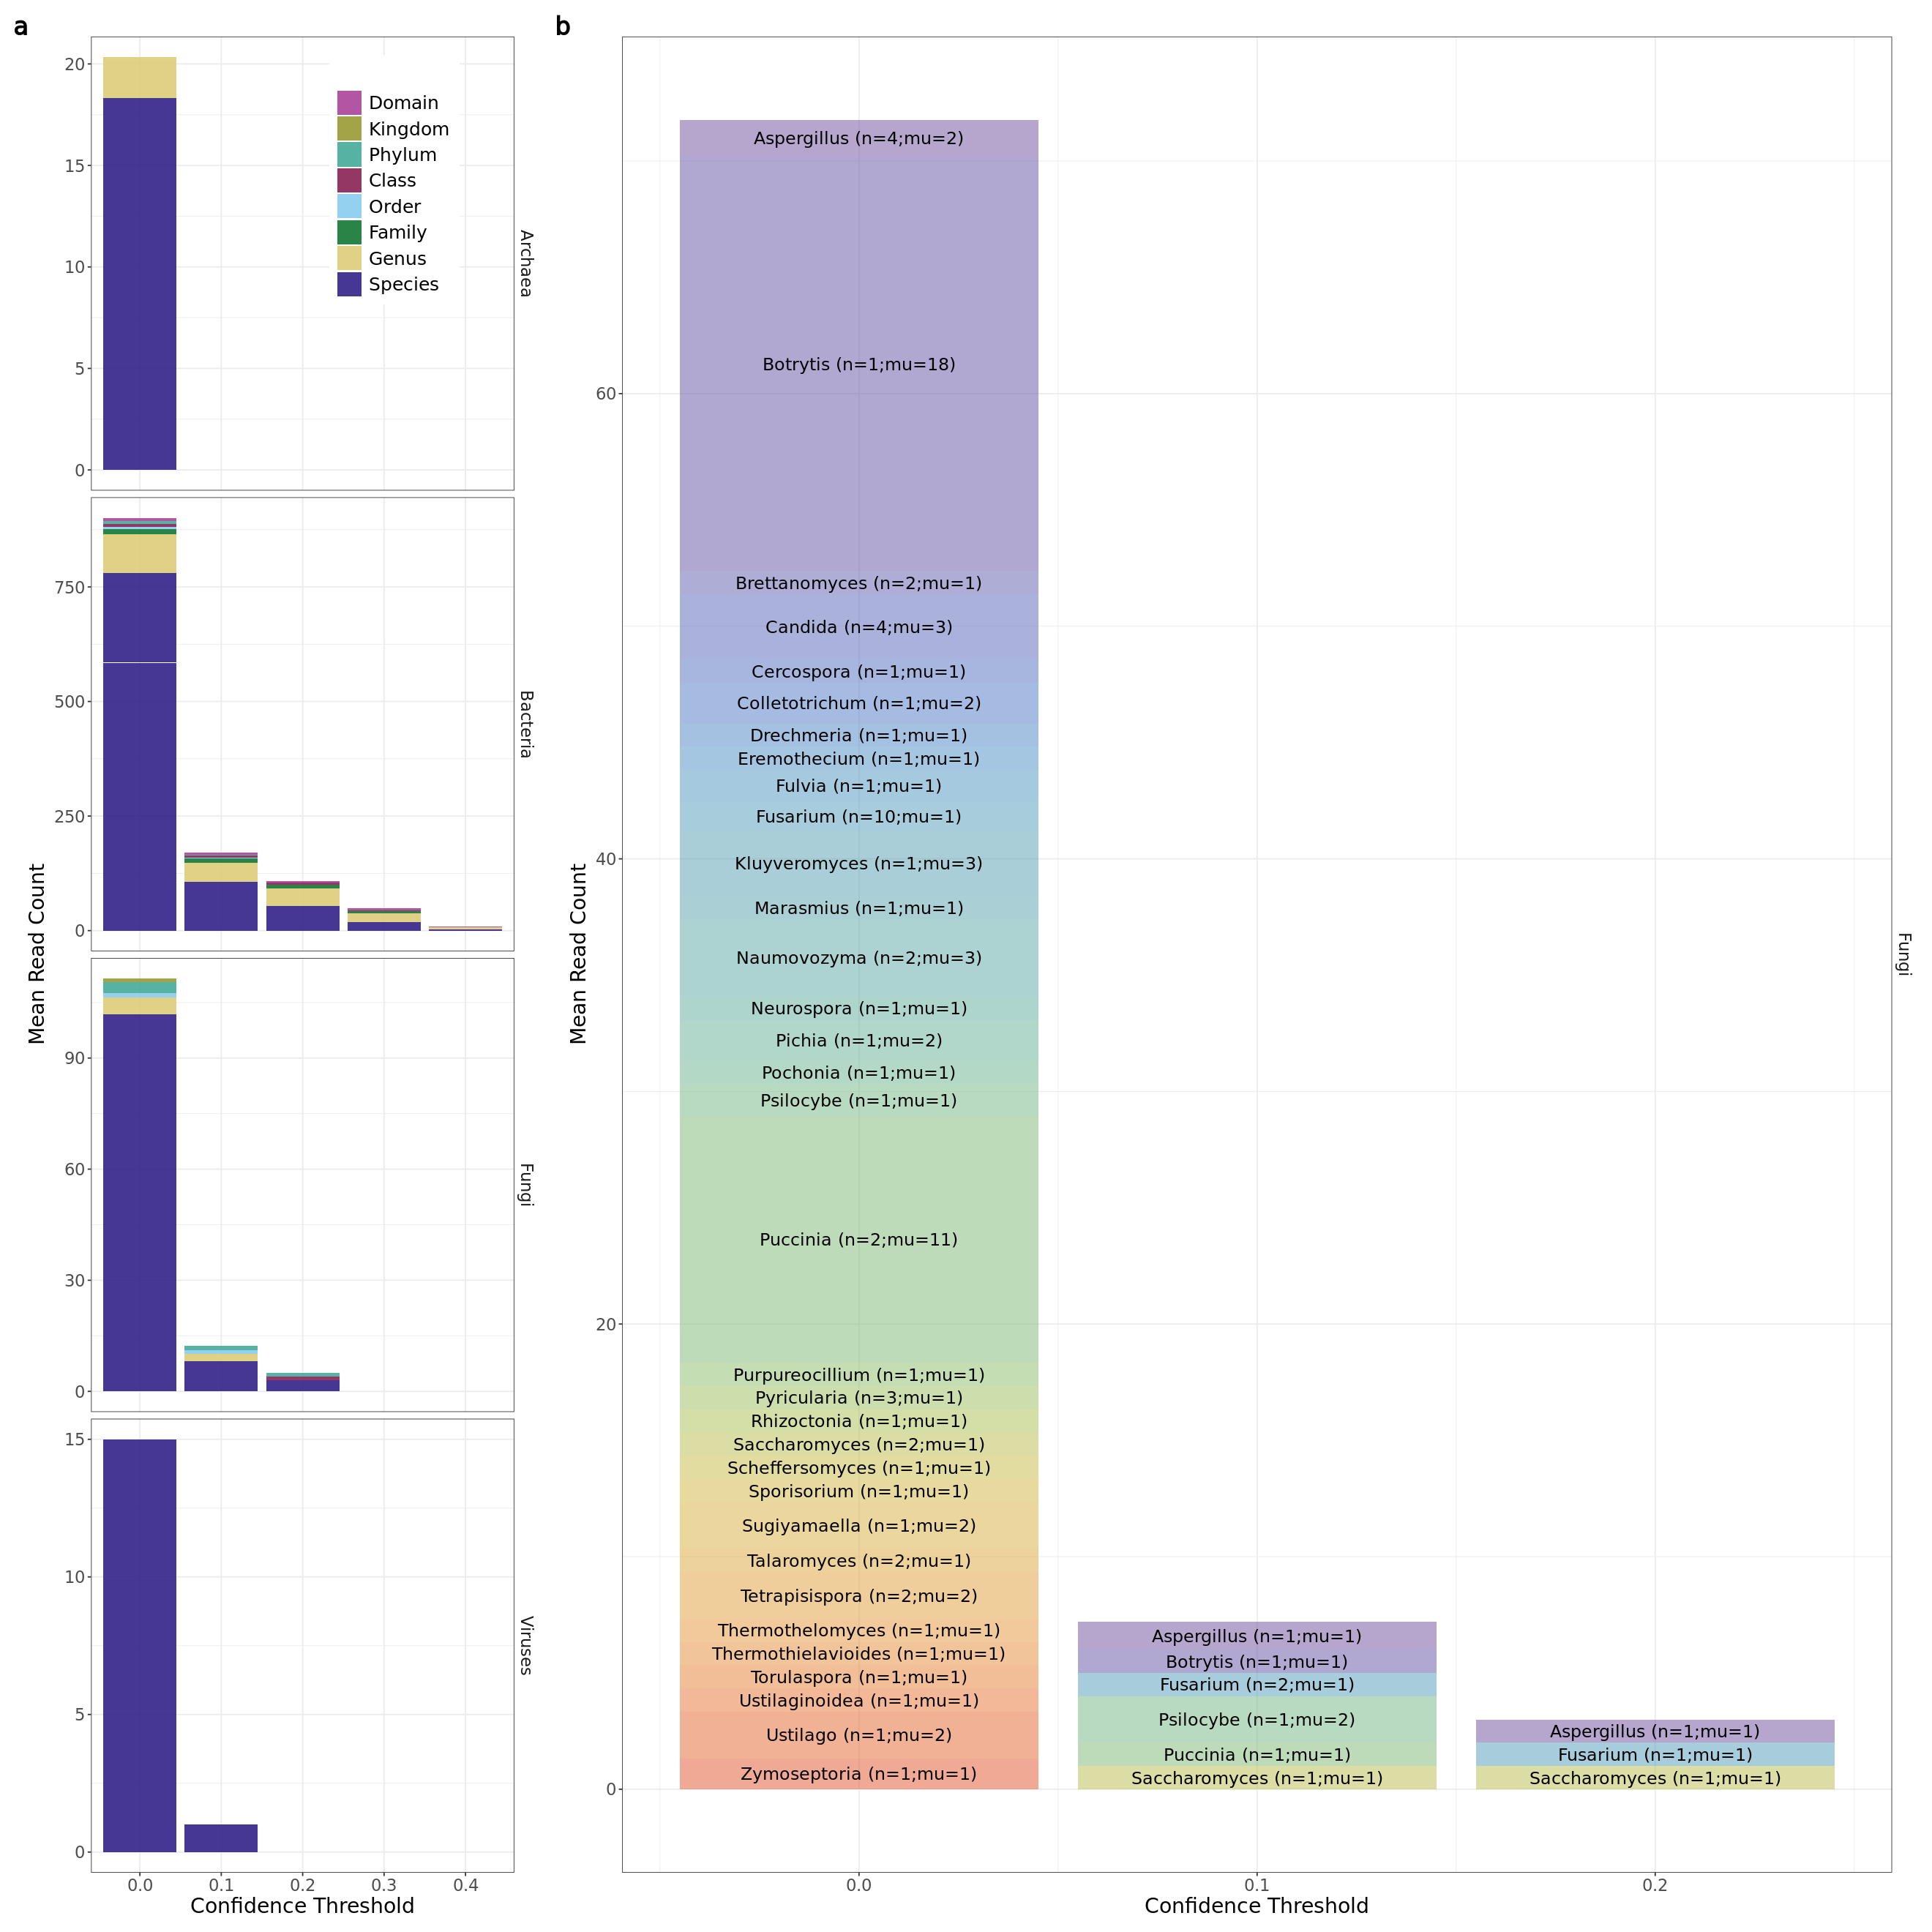

In [17]:
options(repr.plot.width=22, repr.plot.height=22)
SuplFig4 <- plt_micr + plt_fun +
    plot_layout(widths = c(1,3), ncol = 2) &
    plot_annotation(tag_levels = 'a') &
    theme(legend.key.size = unit(0.75, 'cm'), legend.key.height = unit(0.75, 'cm'), legend.key.width = unit(0.75, 'cm'), 
        strip.background = element_blank(),
        text = element_text(size = 17), legend.text = element_text(size = 15, colour = "black"),
        plot.title = element_text(size = 20, hjust = 0, face = "bold"), 
        plot.subtitle = element_text(size = 17, hjust = 0), 
        plot.tag = element_text(face = 'bold', size = 20))

SuplFig4

ggsave("../../output/suppl_figures/SuplFig4_R.png", 
       SuplFig4, width = 20, height = 22)
ggsave("../../output/suppl_figures/SuplFig4_R.pdf", 
       SuplFig4, width = 20, height = 22)